# Travailler les IRM structurelles en Python

Dans ce notebook, vous apprendrez à charger des IRM en mémoire en utilisant le package NiBabel. Avec ce package, vous pourrez importer et travailler vos images IRM structurelles en utilisant Python. Dans ce tutoriel, nous nous intéressons seulement aux images pondérées T1.

## Importer les packages

In [1]:
# Calculs scientifiques
import numpy as np
# Gestion des formats IRM
import nibabel as nib
from scipy.ndimage import zoom
# Création et affichage de graphiques
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import os
import h5py
import tensorflow as tf
from tensorflow.keras import backend as K 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
    BatchNormalization, 
    Dropout,
    ZeroPadding3D,
    Cropping3D,
)
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

2024-09-13 15:17:02.676559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 15:17:02.825086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 15:17:02.871499: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 15:17:03.112901: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 15:17:05.243499: W tensorflow/compiler/tf2

In [2]:
#donner le chemin d'acces pour les images et mask ici pour l'entrainement et le test
path_img_train='data/train/image/'
path_mask_train='data/train/mask/'
path_img_test='data/test/image/'
path_mask_test='data/test/mask/'

In [3]:
def load_brain_mri_dataset(path_img, path_mask):
    """
    Charge les chemins des images IRM et des masques, associe les masques à chaque image, 
   

    Paramètres :
    - path_img : Chemin du dossier contenant les images IRM.
    - path_mask : Chemin du dossier contenant les masques (CSF, matière grise, matière blanche).
 
    Retour :
    - df : DataFrame contenant les chemins des images et des masques associés.
    """

    # Obtenir la liste des fichiers d'images et de masques, en triant ceux qui se terminent par '.nii'
    img_files = sorted([f for f in os.listdir(path_img) if f.endswith('.nii')])
    mask_files = sorted([f for f in os.listdir(path_mask) if f.endswith('.nii')])

    # Créer un dictionnaire pour associer les masques (csf, matière grise, matière blanche) à chaque image
    mask_dict = {}
    for mask_file in mask_files:
        # Extraire un nom de base commun pour l'image et les masques
        base_name = '_'.join(mask_file.split('_')[:2])
        
        # Initialiser l'entrée dans le dictionnaire si elle n'existe pas
        if base_name not in mask_dict:
            mask_dict[base_name] = {}
        
        # Associer chaque masque (CSF, Gray Matter, White Matter) à son nom de fichier correspondant
        if 'csf' in mask_file.lower():
            mask_dict[base_name]['csf'] = os.path.join(path_mask, mask_file)
        elif 'graymatter' in mask_file.lower():
            mask_dict[base_name]['graymatter'] = os.path.join(path_mask, mask_file)
        elif 'whitematter' in mask_file.lower():
            mask_dict[base_name]['whitematter'] = os.path.join(path_mask, mask_file)

    # Construire une liste d'images et de masques combinés
    data = []
    for img_file in img_files:
        # Extraire le nom de base pour l'image et l'utiliser pour retrouver les masques associés
        base_name = '_'.join(img_file.split('_')[:2])
        img_path = os.path.join(path_img, img_file)
        
        # Récupérer les masques associés à cette image dans le dictionnaire
        masks = mask_dict.get(base_name, {})
        csf_mask = masks.get('csf', '')
        graymatter_mask = masks.get('graymatter', '')
        whitematter_mask = masks.get('whitematter', '')
        
        # Ajouter à la liste uniquement si tous les masques (csf, graymatter, whitematter) existent
        if csf_mask and graymatter_mask and whitematter_mask:
            data.append([img_path, csf_mask, graymatter_mask, whitematter_mask])

    # Convertir les données en DataFrame pour faciliter la manipulation
    df = pd.DataFrame(data, columns=['Scan', 'CSF Mask', 'Gray Matter Mask', 'White Matter Mask'])
    return df
    

## Visualisation 

In [4]:

# chargement de la premiere image et ses masks
df=load_brain_mri_dataset(path_img=path_img_train,path_mask=path_mask_train)
df.head()
img=nib.load(df.iloc[1,0]).get_fdata()
csf_mask = nib.load(df.iloc[1,1]).get_fdata()
graymatter_mask = nib.load(df.iloc[1,2]).get_fdata()
whitematter_mask = nib.load(df.iloc[1,3]).get_fdata()

In [5]:
print(img.shape,csf_mask.shape,graymatter_mask.shape,whitematter_mask.shape)

(182, 218, 182) (182, 218, 182) (182, 218, 182) (182, 218, 182)


### Ce code est très pratique pour afficher des coupes de l'image IRM.

In [6]:
def show_slices(slices, titles):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(7, 3))
    for i, (slice, title) in enumerate(zip(slices, titles)):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.show()


#### fonction utilisant la fonction show slices pour afficher 3 coupes

In [7]:
def visualize_img(img):
    """ Fonction pour visualiser les coupes d'images et de masques """

    # Visualisation des coupes pour le scan
    slice_0 = img[120, :, :]
    slice_1 = img[:, 120, :]
    slice_1 = slice_1.T
    slice_1 = np.flip(slice_1, axis=1)
    slice_2 = img[:, :, 90]

    show_slices([slice_0, slice_1, slice_2], ['Coronal Slice', 'Axial Slice', 'Sagittal Slice'])


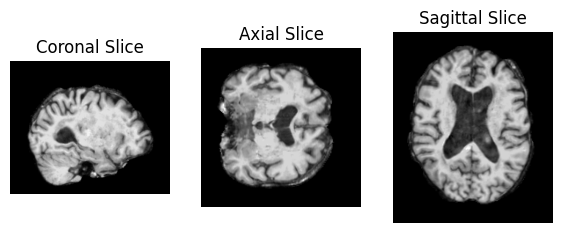

(182, 218, 182)
144.0


In [8]:
visualize_img(img)
print(img.shape)
print(np.max(np.array(img)))


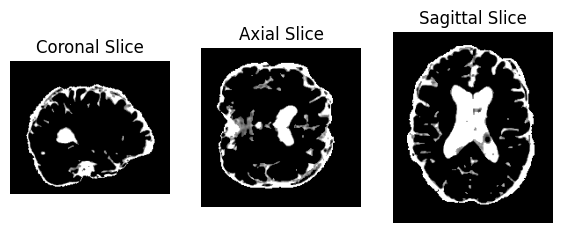

In [9]:
visualize_img(csf_mask)

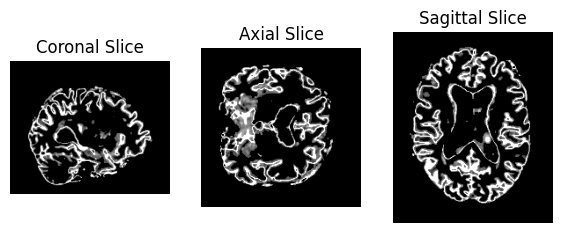

In [10]:
visualize_img(graymatter_mask)

## Fonction pour combiner les masks a des fins de segmentation


#### blanc : Matière blanche
#### moins gris : Liquide cérébrospinal (CSF)
#### tres gris : Matiere grise

In [11]:
def combine_masks_to_single_label(mask_gray, mask_white, mask_csf):
    combined_mask = np.zeros(mask_gray.shape, dtype=np.uint8)
    combined_mask[mask_csf == 1] = 2
    combined_mask[mask_white == 1] = 3
    combined_mask[mask_gray == 1] = 1
    return combined_mask

In [12]:
combined_mask=combine_masks_to_single_label(graymatter_mask,whitematter_mask,csf_mask)
combined_mask = combined_mask.astype(np.float32)

print(combined_mask.shape)
print(np.min(combined_mask), np.max(combined_mask))


(182, 218, 182)
0.0 3.0


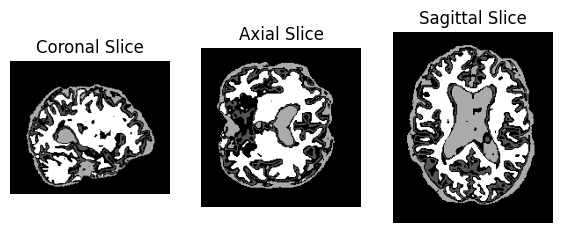

In [13]:
visualize_img(combined_mask)

In [14]:
#to_categorical convertit le masque à étiquette unique en un format 
#one-hot encodé multiclasse, où chaque voxel est représenté par
#un vecteur binaire indiquant sa classe (fond, matière grise, matière blanche, ou LCR).
#pour le modele 
categorical_mask = to_categorical(combined_mask, num_classes=4) # num_classes inclut le fond
print(categorical_mask.shape)

(182, 218, 182, 4)


In [15]:
def save_image(img, affine, output_path):
    """ Sauvegarde l'image combinée dans un fichier NIfTI """
    img = nib.Nifti1Image(combined_mask, affine)
    nib.save(img, output_path)


# Pretaraitement des images et masks

In [16]:
def normalize_min_max(image):
    """
    Normalise l'image en utilisant la méthode Min-Max scaling.
    Les valeurs de l'image seront mises à l'échelle entre 0 et 1.

    Paramètre :
    - image : L'image à normaliser (tenseur ou tableau NumPy).

    Retour :
    - image_normalized : L'image normalisée avec des valeurs entre 0 et 1.
    """
    min_val = image.min()  # Valeur minimale dans l'image
    max_val = image.max()  # Valeur maximale dans l'image
    
    # Appliquer la normalisation Min-Max
    image_normalized = (image - min_val) / (max_val - min_val)
    
    return image_normalized


##  Sub-volume Sampling
Cette fonction est utile dans des tâches de segmentation 3D où le traitement de l'intégralité d'un volume IRM en une seule fois est trop coûteux en termes de mémoire

In [17]:
#Fonction pour generer des patchs d'entrainement 
def get_sub_volume(image, label,output_x = 128,output_y =128 , output_z = 64, num_classes=4,max_tries = 500, background_threshold=0.95):
 
    # Initialize features and labels with `None`
    X = None
    y = None
    orig_x,orig_y,orig_z=image.shape[0],image.shape[1],image.shape[2]
    tries = 0    
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(0, orig_x - output_x+1)
        start_y = np.random.randint(0, orig_y - output_y+1)
        start_z = np.random.randint(0, orig_z - output_z+1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
    
        y = to_categorical(y,num_classes=num_classes)

        # compute the background ratio
        bgrd_ratio = np.sum(y[:,:,:, 0])/(output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z])
            
    
            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")


In [18]:
# fonction implementant le pipeline de traitements d'images pour preparer les donnes au model
# fonction combinant toutes les fonctions de pretraitement : pipeline
def preprocess(image_path, masks_path):
    # Charger les images et les masques
    image = nib.load(image_path).get_fdata()
    m_csf = nib.load(masks_path[0]).get_fdata()
    m_gray=nib.load(masks_path[1]).get_fdata()
    m_white=nib.load(masks_path[2]).get_fdata()
    #Combiner les masks en un seul mask
    mask=combine_masks_to_single_label(mask_gray=m_gray,mask_white=m_white,mask_csf=m_csf)
    #creer des patchs pour l'entrainement:pour l'image et le label ces patchs doivent concorder
    X,y=get_sub_volume(image=image,label=mask)
    #normaliser 
    X=normalize_min_max(X)    
    return X,y

In [19]:
class DataGenerator(Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size, num_classes):
        """
        Générateur de données pour les images et les masques.

        Paramètres :
        - image_filenames : Liste des chemins d'images.
        - mask_filenames : Liste des chemins de masques (avec 3 masques par image).
        - batch_size : Taille des lots.
        - num_classes : Nombre de classes dans les masques (pour l'encodage one-hot).
        """
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.num_classes = num_classes  # Le nombre de classes dans vos masques
        self.on_epoch_end()

    def __len__(self):
        # Retourne le nombre de lots par epoch
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        # Récupérer un lot d'images et de masques
        batch_image_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_filenames = self.mask_filenames[index * self.batch_size:(index + 1) * self.batch_size]

        # Prétraiter chaque image et masque avec la fonction preprocess
        images_and_masks = [preprocess(img_path, mask_paths) for img_path, mask_paths in zip(batch_image_filenames, batch_mask_filenames)]
        
        images = [im for im, _ in images_and_masks]
        masks = [m for _, m in images_and_masks]
        
        # Reshape les images et masques
        images = np.expand_dims(np.array(images), axis=-1)  # Shape: (batch_size, height, width, depth, 1)
        masks = np.array(masks)  # Shape: (batch_size, height, width, depth, num_classes)

        return images, masks

    def on_epoch_end(self):
        # Cette méthode peut être utilisée pour des actions à la fin de chaque epoch (ex: mélange des données)
        pass

# Developpement du modele 

# 1-U-net

 ## Metrics : ici on va utiliser Soft Dice Loss which is based on Dice coefficient utiliser dans la plupart des taches de segmentation
 https://fr.wikipedia.org/wiki/Indice_de_S%C3%B8rensen-Dice

In [20]:

def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), epsilon=0.00001):
    """
    Calcule le coefficient de Dice moyen sur toutes les classes d'anomalies.
    
    Args:
    y_true (Tensorflow tensor): tenseur des valeurs réelles pour toutes les classes.
        forme: (x_dim, y_dim, z_dim, num_classes)
    y_pred (Tensorflow tensor): tenseur des prédictions pour toutes les classes.
        forme: (x_dim, y_dim, z_dim, num_classes)
    axis (tuple): axes spatiaux sur lesquels sommer lors du calcul du numérateur et
        du dénominateur du coefficient de Dice.
    epsilon (float): petite constante ajoutée au numérateur et au dénominateur pour
        éviter les erreurs de division par 0.
    
    Returns:
    dice_coefficient (float): valeur calculée du coefficient de Dice.
    """
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    # Calculer le coefficient de Dice pour chaque classe
    numerator = 2. * K.sum(y_true * y_pred, axis=axis)
    denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis)
    
    # Ajouter epsilon pour éviter la division par zéro
    dice = (numerator + epsilon) / (denominator + epsilon)
    
    # Calculer la moyenne sur toutes les classes
    return K.mean(dice)



In [21]:
# implementation de Soft Dice Loss 
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """
    
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))

    return dice_loss

## Create and train the model

In [2]:
def encoder_block_3d(inputs, num_filters, dropout_rate=0.3):
    """
    Crée un bloc encodeur pour le U-Net 3D avec BatchNormalization et Dropout.
    
    Args:
    - inputs: Tensor d'entrée
    - num_filters: Nombre de filtres pour les couches de convolution
    - dropout_rate: Taux de dropout à appliquer (par défaut 0.3)
    
    Returns:
    - x: Features avant le pooling (pour les connexions skip)
    - p: Features après le pooling (pour le prochain bloc encodeur)
    """
    # Première convolution 3D
    x = Conv3D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Dropout après la première convolution
    x = Dropout(dropout_rate)(x)
    
    # Deuxième convolution 3D
    x = Conv3D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Max pooling 3D (réduction de la résolution spatiale, mais pas en profondeur)
    p = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 1), strides=(2, 2, 1))(x)
    
    return x, p


In [23]:

"""# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling3D((2, 2, 2))(x)
    return x, p   """

'# Encoder block: Conv block followed by maxpooling\ndef encoder_block(input, num_filters):\n    x = conv_block(input, num_filters)\n    p = MaxPooling3D((2, 2, 2))(x)\n    return x, p   '

In [24]:
def decoder_block_3d(inputs, skip_features, num_filters):
    """
    Crée un bloc décodeur pour le U-Net 3D.
    
    Args:
    - inputs: Tensor d'entrée du niveau précédent
    - skip_features: Features de la connexion skip correspondante
    - num_filters: Nombre de filtres pour les couches de convolution
    
    Returns:
    - x: Features décodées
    """
    # Upsampling par convolution transposée 3D
    x =Conv3DTranspose(num_filters, (2, 2, 1), strides=(2, 2, 1), padding='same')(inputs)
    
    # Concaténation avec les features de la connexion skip
    x = Concatenate()([x, skip_features])
    
    # Première convolution 3D suivie d'une activation ReLU
    x = Conv3D(num_filters, 3, padding='same')(x)
    x = Activation('relu')(x)
    
    # Deuxième convolution 3D suivie d'une activation ReLU
    x = Conv3D(num_filters, 3, padding='same')(x)
    x = Activation('relu')(x)
    
    return x

In [25]:
def unet_model_3d(input_shape=(128, 128,64,1), num_classes=4):
    """
    Crée le modèle U-Net 3D complet pour la segmentation des tissus cérébraux.
    
    Args:
    - input_shape: Forme de l'entrée (hauteur, largeur, profondeur, canaux)
    - num_classes: Nombre de classes pour la segmentation
    
    Returns:
    - model: Modèle U-Net 3D compilé
    """
    inputs = tf.keras.layers.Input(input_shape)

    # Chemin de l'encodeur
    s1, p1 = encoder_block_3d(inputs, 64)
    s2, p2 = encoder_block_3d(p1, 128)
    s3, p3 = encoder_block_3d(p2, 256)
    s4, p4 = encoder_block_3d(p3, 512)

    # Bridge (partie la plus profonde du réseau)
    b1 = tf.keras.layers.Conv3D(1024, 3, padding='same')(p4)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv3D(1024, 3, padding='same')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    # Chemin du décodeur
    d1 = decoder_block_3d(b1, s4, 512)
    d2 = decoder_block_3d(d1, s3, 256)
    d3 = decoder_block_3d(d2, s2, 128)
    d4 = decoder_block_3d(d3, s1, 64)

    # Couche de sortie
    outputs = tf.keras.layers.Conv3D(num_classes, 1, padding='same', activation='softmax')(d4)

    # Création du modèle
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net-3D')
    return model


In [26]:
target_shape = (128, 128,64)
num_classes=4
# instanciation du modele
model = unet_model_3d(input_shape=(target_shape[0], target_shape[1], target_shape[2], 1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=[dice_coefficient])
model.summary()

Model: "U-Net-3D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 64, 64,    │      1,792 │ input_layer[0][0] │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ conv3d[0][0]      │
│ (Activation)        │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 64, 64,    │    110,656 │ activation[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (Activation)        │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (MaxPooling3D)      │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 32, 32,    │    221,312 │ max_pooling3d[0]… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ conv3d_2[0][0]    │
│ (Activation)        │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 32, 32,    │    442,496 │ activation_2[0][… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (Activation)        │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 16, 16,    │          0 │ activation_3[0][… │
│ (MaxPooling3D)      │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 16, 16,    │    884,992 │ max_pooling3d_1[… │
│                     │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 16, 16,    │          0 │ conv3d_4[0][0]    │
│ (Activation)        │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 16, 16,    │  1,769,728 │ activation_4[0][… │
│                     │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (Activation)        │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 8, 8, 32,  │          0 │ activation_5[0][… │
│ (MaxPooling3D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 8, 8, 32,  │  3,539,456 │ max_pooling3d_2[

 Total params: 87,507,588 (333.81 MB)

 Trainable params: 87,507,588 (333.81 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
batch_size=2
# Diviser les données en ensembles d'entraînement et de test
train_df, val_df = train_test_split(load_brain_mri_dataset(path_img=path_img_train,path_mask=path_mask_train), test_size=0.3, random_state=42)

# Créer des DataGenarators pour l'entraînement et la validation
train_generator = DataGenerator(train_df['Scan'].tolist(),train_df[['CSF Mask', 'Gray Matter Mask', 'White Matter Mask']].values.tolist(), batch_size=batch_size, num_classes=num_classes)
val_generator = DataGenerator(val_df['Scan'].tolist(),val_df[['CSF Mask', 'Gray Matter Mask', 'White Matter Mask']].values.tolist(), batch_size=batch_size, num_classes=num_classes)

## Entrainement du modele


In [28]:
# Initialisation des listes pour stocker les métriques
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Entraînement
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7,
    callbacks=[
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: (
                train_loss.append(logs['loss']),
                val_loss.append(logs['val_loss']),
                train_accuracy.append(logs['dice_coefficient']),
                val_accuracy.append(logs['val_dice_coefficient'])
            )
        )
    ]
)


Epoch 1/7


/home/josh/Documents/3DSPFA/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-09-13 15:17:34.286133: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 905969664 exceeds 10% of free system memory.
2024-09-13 15:17:34.286267: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 905969664 exceeds 10% of free system memory.
2024-09-13 15:17:38.626219: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1811939328 exceeds 10% of free system memory.
2024-09-13 15:17:38.629755: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1811939328 exceeds 10% of free system memory.
2024-09-13 

18/70 ━━━━━━━━━━━━━━━━━━━━ 58:55 68s/step - dice_coefficient: 0.2243 - loss: 1.4330

### Visualisation de la variation de loss fonctions et l'accuracy 

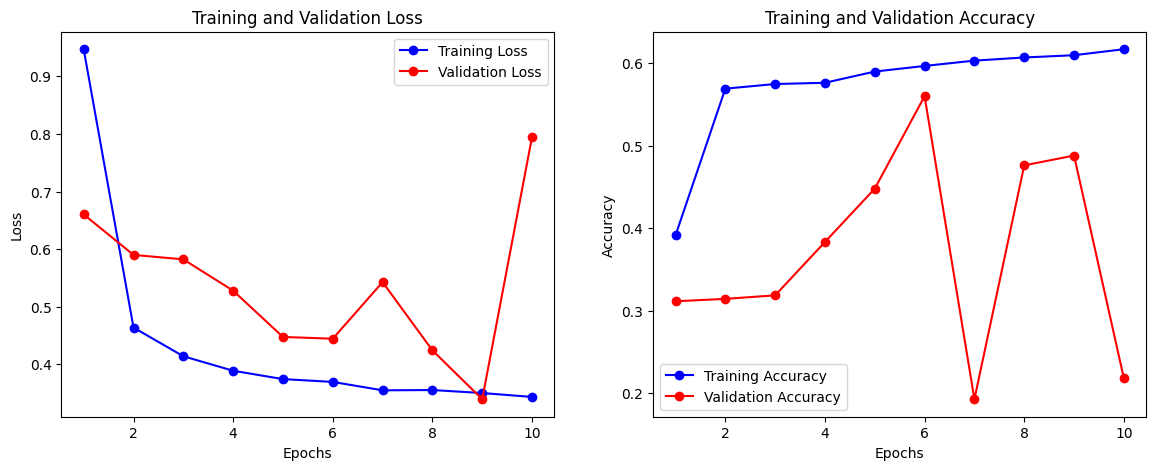

In [29]:
epochs = list(range(1, 11))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
## Sauvgarde du model
model.save('model_cnn.h5')


## Test du modele

In [32]:
batch_size=4
# ensembles  de test
test_df = load_brain_mri_dataset(path_img=path_img_test,path_mask=path_mask_test)

# Créer DataGenarator 
test_generator = DataGenerator(test_df['Scan'].tolist(),test_df[['CSF Mask', 'Gray Matter Mask', 'White Matter Mask']].values.tolist(), batch_size=batch_size, num_classes=num_classes)

In [39]:

# Chargemenent du modele
model1 = load_model('model_cnn.h5', custom_objects={'dice_coefficient': dice_coefficient,'soft_dice_loss':soft_dice_loss})

In [40]:
model.compile(optimizer="adam", loss=soft_dice_loss, metrics=[dice_coefficient])

In [41]:
# Évaluer le modèle sur les données de test
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

386/386 ━━━━━━━━━━━━━━━━━━━━ 305s 786ms/step - dice_coefficient: 0.2182 - loss: 0.7950
Test Loss: 0.7950296998023987
Test Accuracy: 0.21839909255504608


### visualiser une image avec le mask reelle et le mask predit pour une  classe particuliere

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
(128, 128, 16, 4)
0.0 1.0


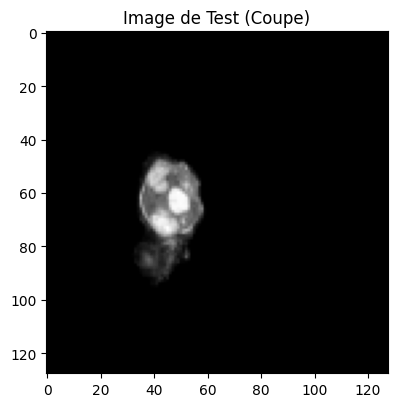

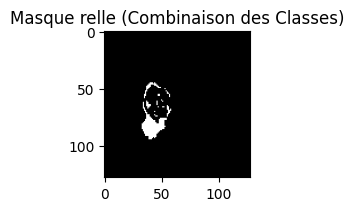

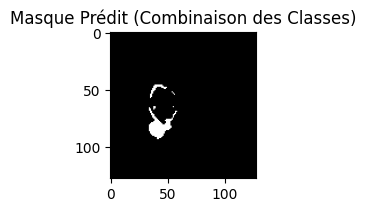

In [45]:
# Sélectionner un lot d'images de test pour la prédiction
test_images, test_masks = test_generator.__getitem__(6)

# Faire des prédictions sur les images de test
predicted_masks = model.predict(test_images)

# Visualiser les résultats
def display_results(test_image, true_mask, predicted_mask, slice_index):
    plt.figure(figsize=(15, 5))

    # Afficher une coupe de l'image de test
    plt.subplot(1, 3, 1)
    plt.imshow(test_image[:, :, slice_index, 0], cmap='gray')
    plt.title('Image de Test (Coupe)')
    plt.show()

    # Afficher le masque réel correspondant
    plt.subplot(1, 3, 1)
    plt.imshow(true_mask[:, :, slice_index,2], cmap='gray') #changer l'index 2:matiere blanche par 0:pour la matiere grise,1:pour le liquide cephalo-rachidien
    plt.title('Masque relle (Combinaison des Classes)')
    plt.show()
    
    # Afficher le masque predit
    plt.subplot(1, 3, 1)
    plt.imshow(predicted_mask[:, :, slice_index,2], cmap='gray') #changer l'index 2:matiere blanche par 0:pour la matiere grise,1:pour le liquide cephalo-rachidien
    plt.title('Masque Prédit (Combinaison des Classes)')
    plt.show()

    plt.show()

# Afficher les résultats pour une coupe spécifique (par exemple, la coupe centrale)
slice_index = 32
# set threshold.
threshold = 0.5

# use threshold to get hard predictions
predicted_masks[0][predicted_masks[0] > threshold] = 1.0
predicted_masks[0][predicted_masks[0] <= threshold] = 0.0
print(predicted_masks[0].shape)
print(np.min(predicted_masks[0]), np.max(predicted_masks[0]))
display_results(test_images[0], test_masks[0], predicted_masks[0], slice_index)

# 2-UnetKAN